<h1> Reddit Sentiment Analysis </h1>

In [1]:
import pandas as pd
import numpy as np
import statsmodels as statsmodels
from statsmodels import graphics
from statsmodels.graphics import gofplots
from statsmodels import api
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
from scipy.stats import ks_2samp
import seaborn as sns

In [2]:
# read data
comments_df = pd.read_csv("~/Desktop/reddit_data_clean.csv")

# select only relevant columns
comments_df = comments_df[["Comment", "Comment Date"]]

In [3]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
comments_df["comment_clean"] = comments_df["Comment"].apply(lambda x: clean_text(x))

In [4]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
comments_df["sentiments"] = comments_df["Comment"].apply(lambda x: sid.polarity_scores(x))
comments_df = pd.concat([comments_df.drop(['sentiments'], axis=1), comments_df['sentiments'].apply(pd.Series)], axis=1)

<h1> Attaching Sentiment Score </h1>

In [5]:
#attaching sentiment score
comments_df['sentiment_type']=''
comments_df.loc[(comments_df.compound>0.5),'sentiment_type']='POSITIVE'
comments_df.loc[(comments_df.compound<-0.5),'sentiment_type']='NEGATIVE'

<AxesSubplot:title={'center':'sentiment analysis'}>

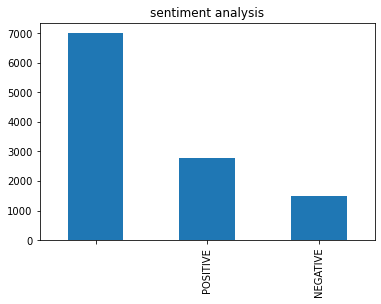

In [6]:
#visualise quantity of sentiment score
comments_df.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")

In [7]:
comments_df['date'] = comments_df['Comment Date'].apply(lambda x: datetime.strptime(x, "%m-%d-%Y, %I:%M%p").date())
new_df = comments_df.pivot_table(index='date',columns='sentiment_type',values='Comment',aggfunc='count')
total_count = comments_df.pivot_table(index='date',values='Comment',aggfunc='count')
compound_df = comments_df.pivot_table(index='date',values='compound',aggfunc='mean')

In [8]:
new_df['TOTAL'] = total_count['Comment']
new_df['COMPOUND'] = compound_df['compound']
new_df['NEGATIVE_P'] = new_df['NEGATIVE']/new_df['TOTAL']
new_df['POSITIVE_P'] = new_df['POSITIVE']/new_df['TOTAL']

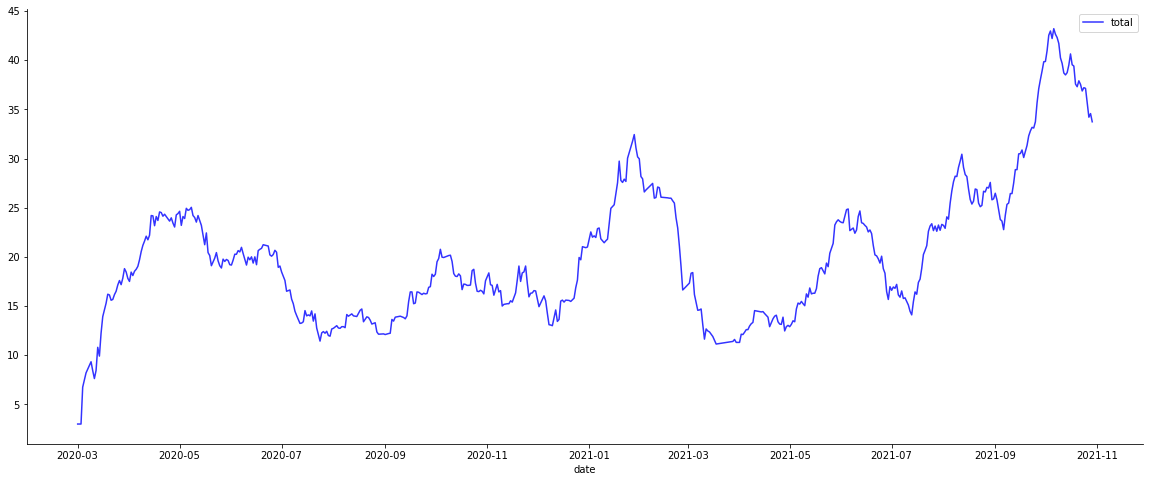

In [10]:
#plots total comments per day over time
plt.figure(facecolor=(1, 1, 1))

rolling_df = new_df.rolling(window=30,min_periods=1).mean()
rolling_df['TOTAL'].plot(figsize=(20,8),label='total', color = 'blue', alpha = 0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()

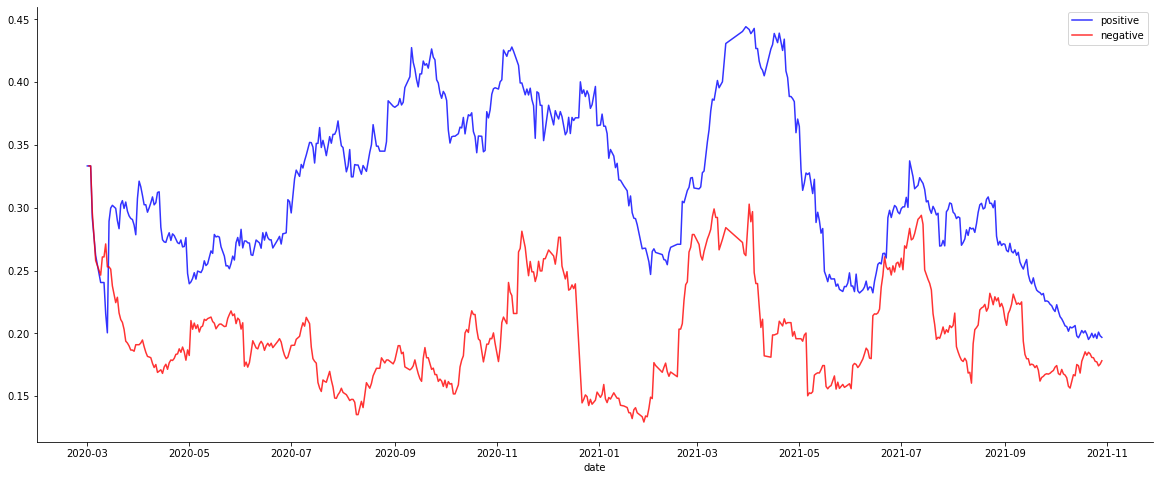

In [9]:
#plots rolling average propportion of positive and negative comments per day over time
plt.figure(facecolor=(1, 1, 1))

rolling_df = new_df.rolling(window=30,min_periods=1).mean()
rolling_df['POSITIVE_P'].plot(figsize=(20,8),label='positive', color = "blue", alpha= 0.8)
rolling_df['NEGATIVE_P'].plot(figsize=(20,8),label='negative', color = "red", alpha = 0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()

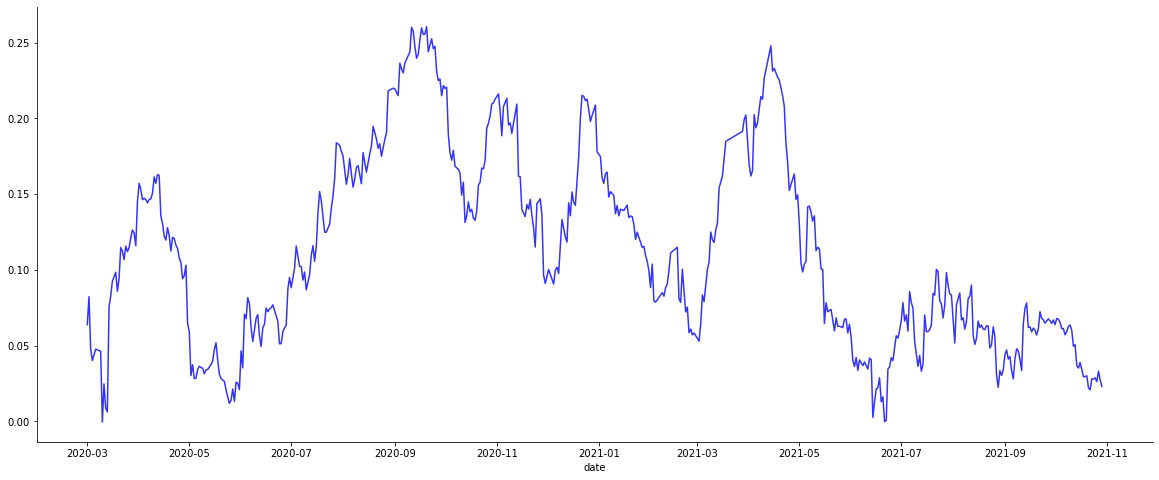

In [12]:
#plots average compound score per day over time 
plt.figure(facecolor=(1, 1, 1))

rolling_df = new_df.rolling(window=30, min_periods=1).mean()
rolling_df['COMPOUND'].plot(figsize=(20,8),label= 'compound', color = 'blue', alpha = 0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

<h1> Kolmogorov Smirnov Two Sample Test </h1>

In [9]:
startdate_1 = datetime.strptime('2020-04-03', "%Y-%m-%d").date()
enddate_1 = datetime.strptime('2020-06-02', "%Y-%m-%d").date()
startdate_2 = datetime.strptime('2021-05-16', "%Y-%m-%d").date()
enddate_2 = datetime.strptime('2021-06-13', "%Y-%m-%d").date()
startdate_3 = datetime.strptime('2021-07-22', "%Y-%m-%d").date()
enddate_3 = datetime.strptime('2021-08-14', "%Y-%m-%d").date()
startdate_4 = datetime.strptime('2021-05-16', "%Y-%m-%d").date()
enddate_4 = datetime.strptime('2021-08-14', "%Y-%m-%d").date()
startdate_5 = datetime.strptime('2021-09-02', "%Y-%m-%d").date()
enddate_5 = datetime.strptime('2021-10-29', "%Y-%m-%d").date()
startdate_6 = datetime.strptime('2020-03-01', "%Y-%m-%d").date()
enddate_6 = datetime.strptime('2021-10-29', "%Y-%m-%d").date()

In [10]:
lockdown = (comments_df['date'] > startdate_1) & (comments_df['date'] <= enddate_1)
heightened_alert_1 = (comments_df['date'] > startdate_2) & (comments_df['date'] <= enddate_2)
heightened_alert_2 = (comments_df['date'] > startdate_3) & (comments_df['date'] <= enddate_3)
combined_HA = (comments_df['date'] > startdate_4) & (comments_df['date'] <= enddate_4)
stabilisation = (comments_df['date'] > startdate_5) & (comments_df['date'] <= enddate_5)
forever = (comments_df['date'] > startdate_6) & (comments_df['date'] <= enddate_6)

#compound score per comment over period
compound1 = comments_df.loc[lockdown]['compound']
compound2 = comments_df.loc[heightened_alert_1]['compound']
compound3 = comments_df.loc[heightened_alert_2]['compound']
compound4 = comments_df.loc[combined_HA]['compound']
compound5 = comments_df.loc[stabilisation]['compound']
compound6 = comments_df.loc[forever]['compound']

In [11]:
#number of comments per day
lockdown = (new_df.index > startdate_1) & (new_df.index <= enddate_1)
heightened_alert_1 = (new_df.index > startdate_2) & (new_df.index <= enddate_2)
heightened_alert_2 = (new_df.index > startdate_3) & (new_df.index <= enddate_3)
combined_HA = (new_df.index > startdate_4) & (new_df.index <= enddate_4)
stabilisation = (new_df.index > startdate_5) & (new_df.index <= enddate_5)
forever = (new_df.index > startdate_6) & (new_df.index <= enddate_6)

total1 = new_df.loc[lockdown]['TOTAL']
total2 = new_df.loc[heightened_alert_1]['TOTAL']
total3 = new_df.loc[heightened_alert_2]['TOTAL']
total4 = new_df.loc[combined_HA]['TOTAL']
total5 = new_df.loc[stabilisation]['TOTAL']
total6 = new_df.loc[forever]['TOTAL']

In [12]:
#number of negative comments per day
negative1 = new_df.loc[lockdown]['NEGATIVE_P']
negative2 = new_df.loc[heightened_alert_1]['NEGATIVE_P']
negative3 = new_df.loc[heightened_alert_2]['NEGATIVE_P']
negative4 = new_df.loc[combined_HA]['NEGATIVE_P']
negative5 = new_df.loc[stabilisation]['NEGATIVE_P']
negative6 = new_df.loc[forever]['NEGATIVE_P']

In [13]:
#number of positive comments per day
positive1 = new_df.loc[lockdown]['POSITIVE']
positive2 = new_df.loc[heightened_alert_1]['POSITIVE']
positive3 = new_df.loc[heightened_alert_2]['POSITIVE']
positive4 = new_df.loc[combined_HA]['POSITIVE']
positive5 = new_df.loc[stabilisation]['POSITIVE']
positive6 = new_df.loc[forever]['POSITIVE']

In [14]:
def ks_2_test(data1, data2):
    test = ks_2samp(data1,data2)
    approx_critical_value = 1.36 * ((len(data1) + len(data2)) / (len(data1) * len(data2)))
    # print("Statistic:" + " " + str(test.statistic))
    # print("P-value:" + " " + str(test.pvalue))
    # print("Critical value:" + " " + str(approx_critical_value))
    # print("Samples come from different distributions:" + " " + str(test.statistic > approx_critical_value))
    return test.pvalue < 0.05

In [100]:
#table of significant differences (based on p-value)
col = ['Lockdown', 'Heightened Alert (1)', 'Heightened Alert (2)', 'Combined_HA', 'Forever']
row = ['Stabilisation']
ks_frame = pd.DataFrame([[False, False, False, False, False]], row, col)

data = [compound1, compound2, compound3, compound4, compound5, compound6]
#data = [total1, total2, total3, total4, total5, total6]
#data = [negative1, negative2, negative3, negative4, negative5, negative6]
#data = [positive1, positive2, positive3, positive4, positive5, positive6]

ks_frame['Lockdown'][0] = ks_2_test(data[3], data[0])
ks_frame['Heightened Alert (1)'][0] = ks_2_test(data[3], data[1])
ks_frame['Heightened Alert (2)'][0] = ks_2_test(data[3], data[2])
ks_frame['Combined_HA'][0] = ks_2_test(data[3], data[3])
ks_frame['Forever'][0] = ks_2_test(data[3], data[5])

In [104]:
#retrieving p-values (in comparison to Stabilisation Phase)

#data = [compound1, compound2, compound3, compound4, compound5, compound6]
#data = [total1, total2, total3, total4, total5, total6]
#data = [negative1, negative2, negative3, negative4, negative5, negative6]
data = [positive1, positive2, positive3, positive4, positive5, positive6]

print('Lockdown: ' + str(ks_2samp(data[4], data[0]).pvalue))
print('HA1: ' + str(ks_2samp(data[4], data[1]).pvalue))
print('HA2: ' + str(ks_2samp(data[4], data[2]).pvalue))
print('Heightened Alert:' + str(ks_2samp(data[4], data[3]).pvalue))
print('Since COVID-19:' + str(ks_2samp(data[4], data[5]).pvalue))

Lockdown: 0.4839181840163208
HA1: 0.13278706829228692
HA2: 0.01727543322031777
Heightened Alert:0.11399443282709332
Since COVID-19:0.13641847377068872


<Figure size 432x288 with 0 Axes>

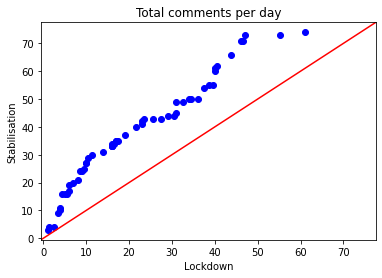

In [94]:
#Q-Q plot for Stabilisation Phase vs Lockdown (Total comments)
data = [total1, total2, total3, total4, total5, total6]

plt.figure(facecolor=(1, 1, 1))
statsmodels.graphics.gofplots.qqplot_2samples(data[0], total5 , xlabel= 'Stabilisation', ylabel= 'Lockdown', line='45')
plt.title("Total comments per day")
plt.show()

<Figure size 432x288 with 0 Axes>

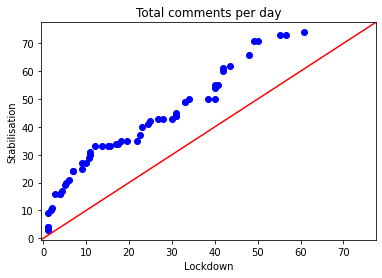

In [95]:
#Q-Q plot for Stabilisation Phase vs Heightened Alert (Total comments)
data = [total1, total2, total3, total4, total5, total6]

plt.figure(facecolor=(1, 1, 1))
statsmodels.graphics.gofplots.qqplot_2samples(data[3], total5 , xlabel= 'Stabilisation', ylabel= 'Lockdown', line='45')
plt.title("Total comments per day")
plt.show()

<Figure size 432x288 with 0 Axes>

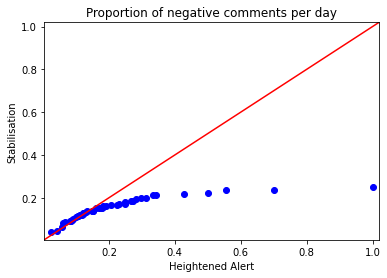

In [96]:
#Q-Q plot for Stabilisation Phase vs Heightened Alert (Negative Proportion)
data = [negative1, negative2, negative3, negative4, negative5, negative6]

plt.figure(facecolor=(1, 1, 1))
statsmodels.graphics.gofplots.qqplot_2samples(data[3], negative5 , xlabel= 'Stabilisation', ylabel= 'Heightened Alert', line='45')
plt.title("Proportion of negative comments per day")
plt.show()

<Figure size 432x288 with 0 Axes>

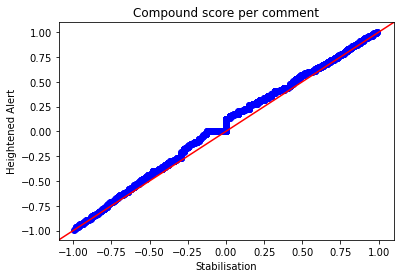

In [97]:
#Q-Q plot for Stabilisation Phase vs Heightened Alert (Compound Score)
data = [compound1, compound2, compound3, compound4, compound5, compound6]

plt.figure(facecolor=(1, 1, 1))
statsmodels.graphics.gofplots.qqplot_2samples(compound5, data[3], xlabel='Heightened Alert', ylabel= 'Stabilisation' , line='45')
plt.title("Compound score per comment")
plt.show()

/Users/zacchaeus/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zacchaeus/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


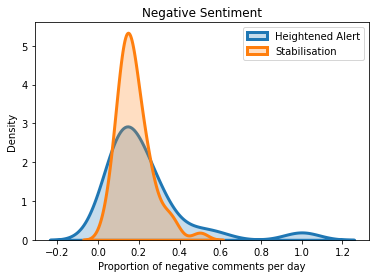

In [92]:
#kernel density plot for Stabilisation Phase vs Heightened Alert (Negative Proportion)
sns.distplot(negative4, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = 'Heightened Alert')
sns.distplot(negative5, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = 'Stabilisation')
plt.title("Negative Sentiment")
plt.xlabel("Proportion of negative comments per day")
plt.legend()

/Users/zacchaeus/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zacchaeus/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


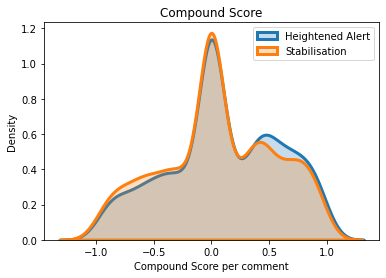

In [93]:
#kernel density plot for Stabilisation Phase vs Heightened Alert (Compound Score)
sns.distplot(compound4, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = 'Heightened Alert')
sns.distplot(compound5, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = 'Stabilisation')
plt.title("Compound Score")
plt.xlabel("Compound Score per comment")
plt.legend()

In [58]:
#calculating proportion of positive comments during Heightened Alert
compound4.between(0.5, 1.0, inclusive = False).sum() / len(compound4)

0.24180327868852458

In [57]:
#calculating proportion of positive comments during Stabilisation Phase
compound5.between(0.5, 1.0, inclusive = False).sum() / len(compound5)

0.20534458509142053

<AxesSubplot:ylabel='Frequency'>

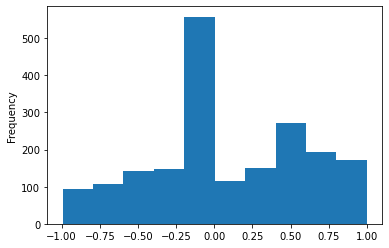

In [20]:
#distribution of compound score of comments over Heightened Alert
compound4.plot.hist()

<AxesSubplot:ylabel='Frequency'>

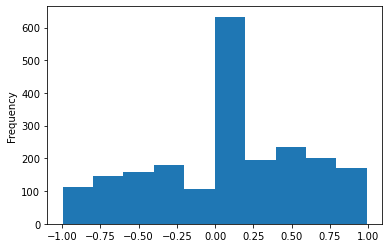

In [21]:
#distribution of compound score of comments over Stabilisation Phase
compound5.plot.hist()

<AxesSubplot:ylabel='Frequency'>

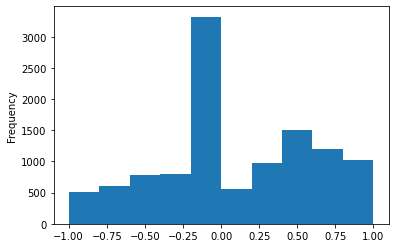

In [37]:
#distribution of compound score of comments over COVID-19 timeline
compound6.plot.hist()